In [5]:
import tensorflow as tf
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# NLP Lab Task — Preprocessing to Deployment with Twitter Sentiment Dataset

## Overview

This lab takes students through the **entire NLP pipeline** using a **Twitter Sentiment Analysis dataset** (tweets labeled as positive, negative, or neutral). Students will preprocess the data, represent it using multiple methods, train classical machine learning models, evaluate their results, and finally build a small API for deployment.

---

## Learning Objectives

* Apply text preprocessing (regex, case folding, tokenization, stopword removal, punctuation handling).
* Compare stemming and lemmatization, and use POS tagging to analyze counts of nouns, verbs, and adjectives.
* Build text representations using **Bag-of-Words**, **TF–IDF**, and **Word2Vec**.
* Train classical ML models inside an sklearn **Pipeline**.
* Evaluate models with standard metrics and perform basic error analysis.
* Save a trained pipeline and build a simple API to serve predictions.

---

## Dataset

We will use the **Sentiment140 Twitter dataset** (1.6M tweets, labeled positive/negative). For simplicity, you can work with a smaller balanced subset (e.g., 10k–20k tweets). This dataset is widely used for sentiment analysis and contains real, noisy text with mentions, hashtags, and emoticons.

Dataset link: [Sentiment140](http://help.sentiment140.com/for-students/)

---

## Step-by-Step Tasks

### 1) Exploratory Data Analysis (EDA)

* Load dataset, show class distribution, tweet length histogram, and a few sample tweets.
* Deliverable: 3 plots (class balance, length histogram, top frequent tokens) + 5 example tweets.

### 2) Regex Cleaning

* Remove URLs, mentions (@user), hashtags, emojis (or replace with tokens), and extra whitespace.
* Show a before-and-after example for at least 3 tweets.

### 3) Case Folding & Tokenization

* Convert all text to lowercase.
* Tokenize tweets using NLTK or spaCy.
* Compare vocabulary size before and after cleaning.

### 4) Stopwords, Punctuation, and Numbers

* Remove stopwords (with NLTK list, customizable).
* Decide how to handle punctuation and numbers (remove or replace with `<NUM>`).
* Deliverable: short explanation of your choice.

### 5) Stemming vs Lemmatization

* Use PorterStemmer (stemming) and spaCy lemmatizer.
* Show 20 sample words with their stem vs lemma.
* Train quick models with both and compare results.

### 6) POS Tagging (extra features)

* Use spaCy to count nouns, verbs, and adjectives per tweet.
* Add these counts as additional numeric features.
* Compare model with vs without POS features.

### 7) Text Representation

* Implement three representations:
  1. **Bag-of-Words** (CountVectorizer)
  2. **TF–IDF** (TfidfVectorizer)
  3. **Word2Vec** (pretrained embeddings, averaged per tweet)
* Compare vocabulary sizes and representation dimensions.

### 8) Modeling with Pipelines

* Use sklearn Pipelines to connect preprocessing + vectorizer + classifier.
* Models to try:
  * Multinomial Naive Bayes (for BoW/TF–IDF)
  * Logistic Regression
  * Linear SVM
* Deliverable: comparison table (accuracy, F1-score).

### 9) Evaluation & Error Analysis

* Use held-out test set.
* Metrics: accuracy, precision, recall, F1, confusion matrix.
* Show 10 misclassified tweets and discuss why they may be difficult.

### 10) Save Model Pipeline

* Save the best pipeline using `joblib` or `pickle`.
* Deliverable: `sentiment_model.pkl` file.

### 11) Build a Simple API (Deployment Step)

* Create a small Flask API with one endpoint `/predict` that accepts a tweet as input and returns sentiment prediction.
* The API should load the saved pipeline and make predictions.
* Deliverable: `app.py` with Flask code + test with a sample curl or Postman request.

---

## Deliverables

1. Jupyter Notebook with step-by-step tasks, results, and code.
2. Comparison tables for preprocessing choices and representations.
3. Saved pipeline file (`.pkl`).
4. Flask API script (`app.py`).
5. Short report in markdown cell summarizing preprocessing, modeling choices, and results.

---

This streamlined lab ensures students get hands-on experience with **real-world text preprocessing, classical modeling, and deployment of NLP systems**.


### 1. Load the Dataset

We will use the **Sentiment140 Twitter Sentiment dataset**.  
It contains 1.6 million tweets labeled as positive (4) or negative (0).  
For this lab, we will load a smaller subset (e.g., 20,000 rows) for faster experimentation.

```python
import pandas as pd

# Column order for Sentiment140 dataset:
# 0 - target (0 = negative, 4 = positive)
# 1 - ids
# 2 - date
# 3 - flag
# 4 - user
# 5 - text (tweet)

# Update the file path if needed
file_path = "sentiment140.csv"

# Load with proper encoding
df = pd.read_csv(file_path, encoding='latin-1', header=None)

# Assign column names
df.columns = ["target", "id", "date", "flag", "user", "text"]

# Map target labels: 0 → negative, 4 → positive
df["target"] = df["target"].map({0: "negative", 4: "positive"})

# Take a smaller sample for experiments (optional)
df = df.sample(20000, random_state=42).reset_index(drop=True)

# Quick check
print(df.shape)
df.head()


In [6]:
import pandas as pd
import zipfile
import os
import requests

# Step 1: Download the dataset (if not already downloaded)
url = "https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"
zip_path = "trainingandtestdata.zip"

if not os.path.exists(zip_path):
    print("Downloading dataset...")
    r = requests.get(url)
    with open(zip_path, "wb") as f:
        f.write(r.content)

# Step 2: Unzip the file
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(".")

# Step 3: Load training data
file_path = "training.1600000.processed.noemoticon.csv"

df = pd.read_csv(file_path, encoding="latin-1", header=None)
df.columns = ["target", "id", "date", "flag", "user", "text"]

# Map sentiment labels: 0 = negative, 4 = positive
df["target"] = df["target"].map({0: "negative", 4: "positive"})

# Optional: sample a smaller dataset for quicker experiments
df = df.sample(20000, random_state=42).reset_index(drop=True)

# Preview the data
print(df.shape)
df.head()


# Load training set
train_path = "training.1600000.processed.noemoticon.csv"
train_df = pd.read_csv(train_path, encoding="latin-1", header=None)
train_df.columns = ["target", "id", "date", "flag", "user", "text"]
train_df["target"] = train_df["target"].map({0: "negative", 4: "positive"})

print("Training set:", train_df.shape)
print(train_df.head())

# Load manual test set
test_path = "testdata.manual.2009.06.14.csv"
test_df = pd.read_csv(test_path, encoding="latin-1", header=None)
test_df.columns = ["target", "id", "date", "flag", "user", "text"]

# This test set has labels 0 (negative), 2 (neutral), 4 (positive)
test_df["target"] = test_df["target"].map({0: "negative", 2: "neutral", 4: "positive"})

print("Test set:", test_df.shape)
print(test_df.head())


(20000, 6)
Training set: (1600000, 6)
     target          id                          date      flag  \
0  negative  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1  negative  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2  negative  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3  negative  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4  negative  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  
Test set: (498, 6)
     target  id                          date     flag      user  \
0  positive   3  Mon May 11 03:17:40 UTC

### EDA

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [8]:
df

,target,id,date,flag,user,text
0,negative,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,negative,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
2,negative,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
3,negative,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
4,negative,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem
...,...,...,...,...,...,...
19995,positive,1981517014,Sun May 31 09:19:12 PDT 2009,NO_QUERY,gemmaridlington,Loving the weather Although we're not having ...
19996,negative,2245469775,Fri Jun 19 16:10:38 PDT 2009,NO_QUERY,musicroxmysockz,Me and andrea r. last day of school..... http...
19997,positive,2063022808,Sun Jun 07 01:05:46 PDT 2009,NO_QUERY,ElaineToni,Just finished watching Your Song Presents: Boy...
19998,positive,1982082859,Sun May 31 10:29:36 PDT 2009,NO_QUERY,lindseyrd20,@janfran813 awww i can't wait to get one


In [9]:
print('duplicates:',df.duplicated().sum())
print('nulls:',df.isna().sum().sum())

duplicates: 0
nulls: 0


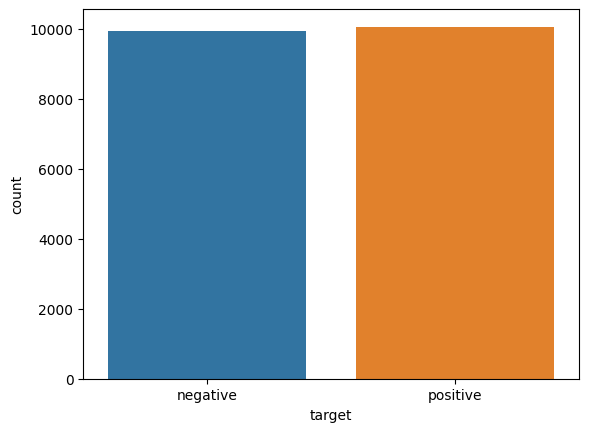

positive    0.5029
negative    0.4971
Name: target, dtype: float64


In [10]:
sns.countplot(data=df,x='target')
plt.show()
print(df['target'].value_counts(normalize=True))

- classes are really well balanced

In [11]:
import nltk
import spacy

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Youss\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


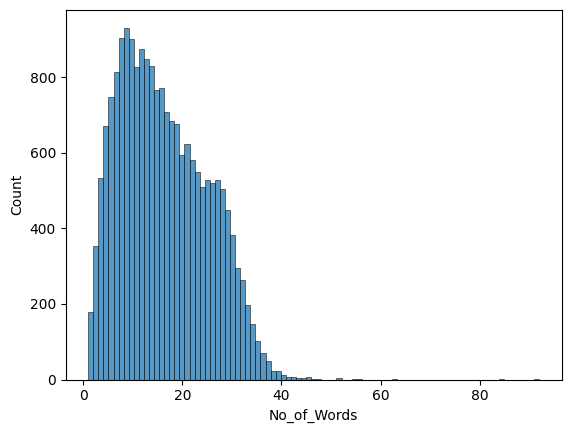

mean =  16.40305


In [12]:
nltk.download('punkt')
df["No_of_Words"] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1).apply(len)

sns.histplot(data=df,x='No_of_Words')
plt.show()
print("mean = ",df['No_of_Words'].mean())

In [13]:
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))
punctuations = set(string.punctuation)
freq_dict = {}

for tweet in df['text']:
    tokens = nltk.word_tokenize(tweet.lower())
    for token in tokens:
        if token not in stop_words and token not in punctuations:
            freq_dict[token] = freq_dict.get(token, 0) + 1

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Youss\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
freq = pd.Series(data=freq_dict)
freq.sort_values(ascending=False).head(10)

...     2751
's      2191
n't     2191
'm      1682
..      1316
good    1143
get     1010
day     1003
like     982
quot     967
dtype: int64

In [15]:
pd.set_option("display.max_colwidth", None)
print(df['text'])

0                                                                                                           @chrishasboobs AHHH I HOPE YOUR OK!!! 
1                                                                                        @misstoriblack cool , i have no tweet apps  for my razr 2
2        @TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u
3                                                      School email won't open  and I have geography stuff on there to revise! *Stupid School* :'(
4                                                                                                                           upper airways problem 
                                                                           ...                                                                    
19995                                      Loving the weather  Although we're not having a bbq this evening as apparen

### Preprocessing

In [16]:
df['target_encoded'] = df['target'].map({'negative': 0, 'positive': 1})
df['target_encoded']

0        0
1        0
2        0
3        0
4        0
        ..
19995    1
19996    0
19997    1
19998    1
19999    0
Name: target_encoded, Length: 20000, dtype: int64

#### Regex Cleaning

In [20]:
import re
def regex_clean(tweet):
    tweet = re.sub(r"http\S+|www\S+", "", tweet)
    tweet = re.sub(r"@\w+", "", tweet)
    tweet = re.sub(r"#\w+", "", tweet)
    tweet = re.sub(r"[^a-zA-Z\s!?]", "", tweet) #left ?,! as they could show emotion not just words
    tweet = re.sub(r"\s+", " ", tweet).strip()
    return tweet

df['regex_text'] = df['text'].apply(regex_clean)

df[['text','regex_text']].head()



,text,regex_text
0,@chrishasboobs AHHH I HOPE YOUR OK!!!,AHHH I HOPE YOUR OK!!!
1,"@misstoriblack cool , i have no tweet apps for my razr 2",cool i have no tweet apps for my razr
2,"@TiannaChaos i know just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u",i know just family drama its lamehey next time u hang out with kim n u guys like have a sleepover or whatever ill call u
3,School email won't open and I have geography stuff on there to revise! *Stupid School* :'(,School email wont open and I have geography stuff on there to revise! Stupid School
4,upper airways problem,upper airways problem


#### Case Folding & Tokenization

In [21]:
df['case_re_text'] = df['regex_text'].apply(lambda x:x.lower())
df[['regex_text','case_re_text']].head()

,regex_text,case_re_text
0,AHHH I HOPE YOUR OK!!!,ahhh i hope your ok!!!
1,cool i have no tweet apps for my razr,cool i have no tweet apps for my razr
2,i know just family drama its lamehey next time u hang out with kim n u guys like have a sleepover or whatever ill call u,i know just family drama its lamehey next time u hang out with kim n u guys like have a sleepover or whatever ill call u
3,School email wont open and I have geography stuff on there to revise! Stupid School,school email wont open and i have geography stuff on there to revise! stupid school
4,upper airways problem,upper airways problem


In [22]:
import spacy

nlp = spacy.load('en_core_web_sm')

df['tokenized_case_re_text'] = df['case_re_text'].apply(lambda x: [token for token in nlp(x)])
df[['case_re_text','tokenized_case_re_text']].head()

,case_re_text,tokenized_case_re_text
0,ahhh i hope your ok!!!,"[ahhh, i, hope, your, ok, !, !, !]"
1,cool i have no tweet apps for my razr,"[cool, i, have, no, tweet, apps, for, my, razr]"
2,i know just family drama its lamehey next time u hang out with kim n u guys like have a sleepover or whatever ill call u,"[i, know, just, family, drama, its, lamehey, next, time, u, hang, out, with, kim, n, u, guys, like, have, a, sleepover, or, whatever, ill, call, u]"
3,school email wont open and i have geography stuff on there to revise! stupid school,"[school, email, wo, nt, open, and, i, have, geography, stuff, on, there, to, revise, !, stupid, school]"
4,upper airways problem,"[upper, airways, problem]"


#### Stop words removal

In [23]:
stop_words = set(stopwords.words("english"))

df['tokenized_no_stop'] = df['tokenized_case_re_text'].apply(lambda x: [token for token in x if token not in stop_words])
df[['tokenized_case_re_text','tokenized_no_stop']].head()

,tokenized_case_re_text,tokenized_no_stop
0,"[ahhh, i, hope, your, ok, !, !, !]","[ahhh, i, hope, your, ok, !, !, !]"
1,"[cool, i, have, no, tweet, apps, for, my, razr]","[cool, i, have, no, tweet, apps, for, my, razr]"
2,"[i, know, just, family, drama, its, lamehey, next, time, u, hang, out, with, kim, n, u, guys, like, have, a, sleepover, or, whatever, ill, call, u]","[i, know, just, family, drama, its, lamehey, next, time, u, hang, out, with, kim, n, u, guys, like, have, a, sleepover, or, whatever, ill, call, u]"
3,"[school, email, wo, nt, open, and, i, have, geography, stuff, on, there, to, revise, !, stupid, school]","[school, email, wo, nt, open, and, i, have, geography, stuff, on, there, to, revise, !, stupid, school]"
4,"[upper, airways, problem]","[upper, airways, problem]"


- left the ! and ? as they have a sentimental meaning

#### Stemming & Lemmitization

In [24]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
nlp = spacy.load("en_core_web_sm")

df['stem_tokens'] = df['tokenized_no_stop'].apply(lambda x:[stemmer.stem(str(token)) for token in x])
df['lemma_tokens'] = df['tokenized_no_stop'].apply(lambda x:[nlp(str(token))[0].lemma_ for token in x])

df[['tokenized_no_stop','stem_tokens','lemma_tokens']].head()

,tokenized_no_stop,stem_tokens,lemma_tokens
0,"[ahhh, i, hope, your, ok, !, !, !]","[ahhh, i, hope, your, ok, !, !, !]","[ahhh, I, hope, your, ok, !, !, !]"
1,"[cool, i, have, no, tweet, apps, for, my, razr]","[cool, i, have, no, tweet, app, for, my, razr]","[cool, I, have, no, tweet, app, for, my, razr]"
2,"[i, know, just, family, drama, its, lamehey, next, time, u, hang, out, with, kim, n, u, guys, like, have, a, sleepover, or, whatever, ill, call, u]","[i, know, just, famili, drama, it, lamehey, next, time, u, hang, out, with, kim, n, u, guy, like, have, a, sleepov, or, whatev, ill, call, u]","[I, know, just, family, drama, its, lamehey, next, time, u, hang, out, with, kim, n, u, guy, like, have, a, sleepover, or, whatever, ill, call, u]"
3,"[school, email, wo, nt, open, and, i, have, geography, stuff, on, there, to, revise, !, stupid, school]","[school, email, wo, nt, open, and, i, have, geographi, stuff, on, there, to, revis, !, stupid, school]","[school, email, will, not, open, and, I, have, geography, stuff, on, there, to, revise, !, stupid, school]"
4,"[upper, airways, problem]","[upper, airway, problem]","[upper, airway, problem]"


In [27]:
df['lemma_text'] = df['lemma_tokens'].apply(lambda x: " ".join(x))
df['stem_text'] =df['stem_tokens'].apply(lambda x: " ".join(x))

In [28]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['target_encoded'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['target_encoded'], random_state=42)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

Train: (14000, 16)
Val: (3000, 16)
Test: (3000, 16)


- note: no data leakage as there is nothing dependent on the data itself from all the previous preprocessing

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X_train_tfidf_lemma = tfidf.fit_transform(train_df['lemma_text'])
X_val_tfidf_lemma = tfidf.transform(val_df['lemma_text'])
print(X_tfidf.shape)
print(X.shape)


(20000, 5000)
